In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")

# <font face="gotham" color="purple">Ornstein-Uhlenbeck Process</font>

The famous **Ornstein-Uhlenbeck Process** takes the form
$$
d x_t=\theta\left(\mu-x_t\right) d t+\sigma d W_t
$$
which is a stationary process in contrast to Wiener process. $\mu$ represents the equilibrium value, $\theta$ is the rate of reverting to equilibrium.

This process can be used for modeling interest rate and FX rate in pair trading strategy, which is making use of **mean reversion** feature of certain assets.

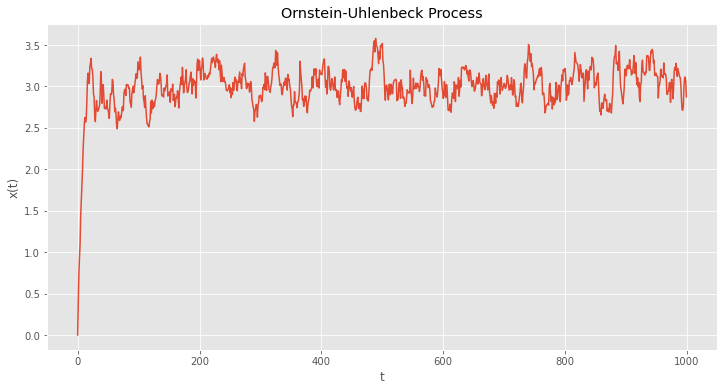

In [26]:
def gen_OU_process(dt=0.1, theta=1.2, mu=0.5, sigma=0.3, n=1000):
    x = np.zeros(n)  # initiate the series
    for t in range(1, n):
        x[t] = (
            x[t - 1]
            + theta * (mu - x[t - 1]) * dt
            + sigma * np.random.normal(0, np.sqrt(dt))
        )
    return x


def plot_process(x):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x)
    ax.set_xlabel("t")
    ax.set_ylabel("x(t)")
    ax.set_title("Ornstein-Uhlenbeck Process")
    plt.show()


if __name__ == "__main__":
    x = gen_OU_process(mu=3)
    plot_process(x)

# <font face="gotham" color="purple">Vasicek Model</font>

The model is named after Czech mathematician Oldřich Vašíček, which assumes that short term interest rate $r(t)$ follows a mean-reverting Ornstein-Uhlenbeck Process.
$$
dr(t) = \kappa (\theta-r(t))dt +\sigma d W(t)
$$
where $dr(t)$ is the change of $r(t)$, $\kappa$ is the speed of mean reversion, other parameters the same as in Ornstein-Uhlenbeck Process. Note that this model allows negative interest rate.

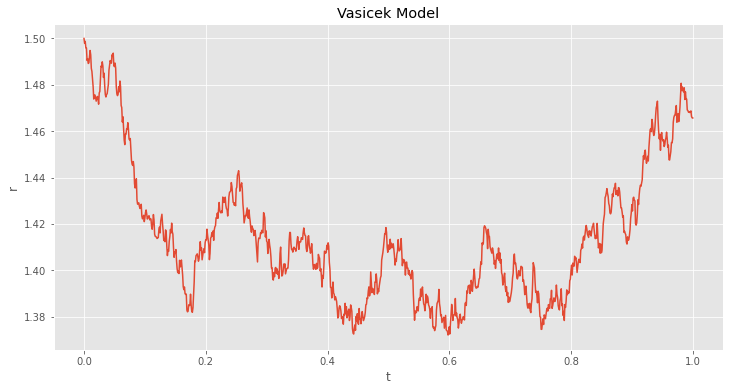

In [36]:
def vasicek_model(r0, kappa, theta, sigma, T=1, N=1000):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    rates = [r0]

    for i in range(N):
        dr = kappa * (theta - rates[-1]) * dt + sigma * np.random.normal(0, np.sqrt(dt))
        rates.append(rates[-1] + dr)

    return t, rates


def plot_process(t, r):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(t, r)
    ax.set_xlabel("t")
    ax.set_ylabel("r")
    ax.set_title("Vasicek Model")
    plt.show()


if __name__ == "__main__":
    t, rates = vasicek_model(1.5, 0.01, 1.5, 0.1)
    plot_process(t, rates)

# <font face="gotham" color="purple"> Bond Valuation with Vasicek Model</font>

As a reminder, this is the continuous compounding formula assuming a constant $r$
$$
P(t) = P_0 e^{rt}
$$

If $r(t)$ is a continuous stochastic process, then present value of an asset can be presented by
$$
P_0 = P(t)\exp{\left(-\int_t^Tr(s)ds\right)}
$$

bond price based on MC: 934.6755874861849


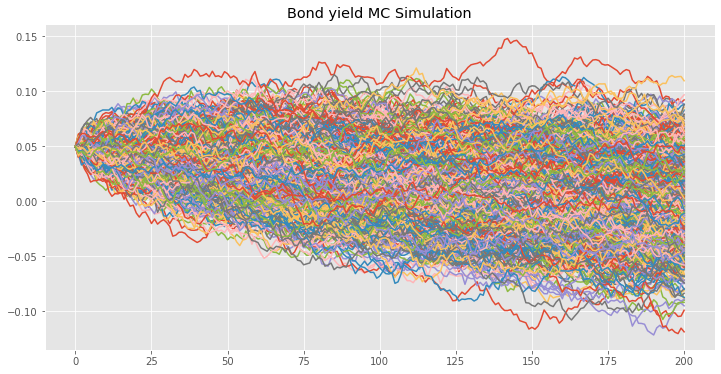

In [60]:
num_of_simu = 1000
num_of_points = 200


def mc_vasicek_bonds(P, r0, kappa, theta, sigma, T=1):
    # P: principal of bond, T=1 one year
    dt = T / num_of_points
    results = []

    for i in range(num_of_simu):
        rates = [r0]
        for j in range(num_of_points):
            dr = kappa * (theta - rates[-1]) * dt + sigma * np.random.normal(
                0, np.sqrt(dt)
            )
            rates.append(rates[-1] + dr)
        results.append(rates)
    simu_data = pd.DataFrame(results).T

    integral_sum = simu_data.sum() * dt
    pv_integral_sum = np.exp(-integral_sum)
    bond_price = P * np.mean(pv_integral_sum)
    print("bond price based on MC: {}".format(bond_price))

    return simu_data


def plot_process(simu_data):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(simu_data)
    # ax.set_xlabel('t')
    # ax.set_ylabel('r')
    ax.set_title("Bond yield MC Simulation")
    plt.show()


if __name__ == "__main__":
    simu_data = mc_vasicek_bonds(
        P=1000, r0=0.05, kappa=0.3, theta=-0.03, sigma=0.03, T=3
    )
    plot_process(simu_data)

The solution of **Stochastic Differential Equations** (SDE) is a probability density function, however very few has closed-form solution.

## <font face="gotham" color="purple"> Refresh of Ordinary Differential Equations</font>

There are four types solution methods of **Ordinary Differential Equation** (ODE): separable equations, homogeneous method, integration factor and exact differential equations.  

### <font face="gotham" color="purple"> Separable Equations </font>

Usual form
$$
\frac{d y}{d x}=P(x) Q(y)
$$

$$
\begin{align}
\frac{dy}{dx} +2xy &= x\\
\int^y\frac{1}{1-2y} dy &= \int^x x dx\\
-\frac{1}{2}\ln{|1-2y|}&=\frac{1}{2}x^2+C
\end{align}
$$
Then isolate $y$, which gives us a closed-form solution.

### <font face="gotham" color="purple"> Homogeneous Method </font>

The homogeneous form ODE can be check by using
$$
f(kx, ky) = f(x, y)
$$

$$
\frac{d y}{d x}=\frac{x^2+y^2}{x y}
$$

$$
\frac{d y}{d x}=\frac{\frac{x^2}{x^2}+\frac{y^2}{x^2}}{\frac{x y}{x^2}} \rightarrow \frac{d y}{d x}=\frac{1+\left(\frac{y}{x}\right)^2}{\frac{y}{x}}
$$

Replace $v=\frac{y}{x}$

$$
\begin{aligned}
& \frac{\partial y}{\partial x}=\frac{1+v^2}{v} \\
& x \frac{\partial v}{\partial x}+v=\frac{1+v^2}{v}\\
& x \frac{\partial v}{\partial x}+v=\frac{1}{v}+{v}
\end{aligned}
$$

$$
\begin{aligned}
& \int v d v=\int \frac{1}{x} d x \\
& \frac{1}{2} v^2=\ln |x|+c \\
& v^2=2 \ln |x|+c \\
& v=\pm \sqrt{2 \ln |x|+c}\\
& y = \pm x \sqrt{2 \ln|x|+c}
\end{aligned}
$$

## <font face="gotham" color="purple">Stochastic Differential Equations</font>

$$
\text{SDE=ODE + GWN}
$$
where $\text{GWN}$ stands for Gaussian White Noise.

The **Brownian motion** , sometimes also know as **Wiener process**, is a fractal in nature, the function will not be differentiable with a well-defined gradient. A standard Brownian motion has following characteristics

$$
\begin{aligned}
W(0) & =0 \text { a.s. } \\
E[W(t)] & =0(\mu=0) \\
E\left[W^2(t)\right] & =t\left(\sigma^2=1\right)
\end{aligned}
$$

However, due to fractal nature
$$
\frac{W_t}{t}
$$
does not exist.